# Portfolio Models in HARK

In this notebook, we consider the solution and simulation of a number of microeconomic problems in the context of optimal portfolio choice.

The agents in this model are first defined using the dictionary from the `PerfForesightConsumerType` class and additional attributes are added using the `IndShockConsumerType` class.

From there, the `ConsPortfolioDict` dictionary is introduced to create the `PortfolioConsumerType` and each of the subseqeunt agent types using it.

In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import (
    dist_params,
    income_params,
    init_lifecycle,
    liv_prb,
    time_params,
)
from HARK.ConsumptionSaving.ConsPortfolioModel import (
    PortfolioConsumerType,
)
from HARK.utilities import plot_funcs

## 1. The baseline model of optimal portfolio choice

In [2]:
# Initial attempt for defining a dictionary for the Portfolio consumer type -- needs to be tested!

ConsPortfolioDict = {
    # Parameters shared with the Perfect foresight consumer type
    "CRRA": 5.0,  # Coefficient of relative risk aversion,
    "Rfree": 1.03,  # Interest factor on assets
    "DiscFac": 0.90,  # Intertemporal discount factor
    "LivPrb": [0.98],  # Survival probability
    "PermGroFac": [1.01],  # Permanent income growth factor
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint
    "MaxKinks": 400,  # Maximum number of grid points to allow in cFunc (should be large)
    "AgentCount": 10000,  # Number of agents of this type (only matters for simulation)
    "aNrmInitMean": 0.0,  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd": 1.0,  # Standard deviation of log initial assets (only for simulation)
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor: portion of PermGroFac attributable to aggregate productivity growth (only matters for simulation)
    "T_age": None,  # Age after which simulated agents are automatically killed
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    "PerfMITShk": False,  # Do Perfect Foresight MIT Shock: Forces Newborns to follow solution path of the agent he/she replaced when True
    # assets above grid parameters
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 100,  # Maximum end-of-period "assets above minimum" value
    "aXtraNestFac": 1,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount": 200,  # Number of points in the grid of "assets above minimum"
    "aXtraExtra": None,  # Some other value of "assets above minimum" to add to the grid, not used
    # Income process variables
    "PermShkStd": [0.1],  # Standard deviation of log permanent income shocks
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.1],  # Standard deviation of log transitory income shocks
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "UnempPrbRet": 0.005,  # Probability of "unemployment" while retired
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "tax_rate": 0.0,  # Flat income tax rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "vFuncBool": False,  # Whether to calculate the value function during solution
    "CubicBool": False,  # Use cubic spline interpolation when True, linear interpolation when False
    "neutral_measure": False,  # Use permanent income neutral measure (see Harmenberg 2021) during simulations when True.
    "NewbornTransShk": False,  # Whether Newborns have transitory shock. The default is False.
    # Attributes specific to the Portfolio consumer
    "RiskyAvg": 1.08,  # Average return of the risky asset
    "RiskyStd": 0.20,  # Standard deviation of (log) risky returns
    "RiskyCount": 5,  # Number of integration nodes to use in approximation of risky returns
    "ShareCount": 25,  # Number of discrete points in the risky share approximation
    "AdjustPrb": 1.0,  # Probability that the agent can adjust their risky portfolio share each period
    "DiscreteShareBool": False,  # Flag for whether to optimize risky share on a discrete grid only
}

In [3]:
# Make and solve an example portfolio choice consumer type
print("Now solving an example portfolio choice problem; this might take a moment...")
MyType = PortfolioConsumerType(**ConsPortfolioDict)
MyType.cycles = 0
t0 = time()
MyType.solve()
t1 = time()
MyType.cFunc = [MyType.solution[t].cFuncAdj for t in range(MyType.T_cycle)]
MyType.ShareFunc = [MyType.solution[t].ShareFuncAdj for t in range(MyType.T_cycle)]
print(
    "Solving an infinite horizon portfolio choice problem took "
    + str(t1 - t0)
    + " seconds.",
)

Now solving an example portfolio choice problem; this might take a moment...
Solving an infinite horizon portfolio choice problem took 10.218280553817749 seconds.


Consumption function over market resources:


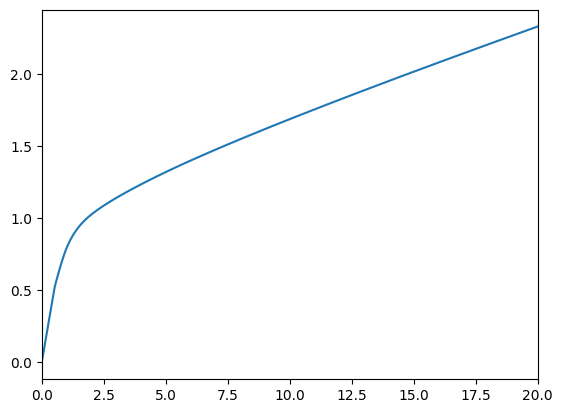

Risky asset share as a function of market resources:
Optimal (blue) versus Theoretical Limit (orange)


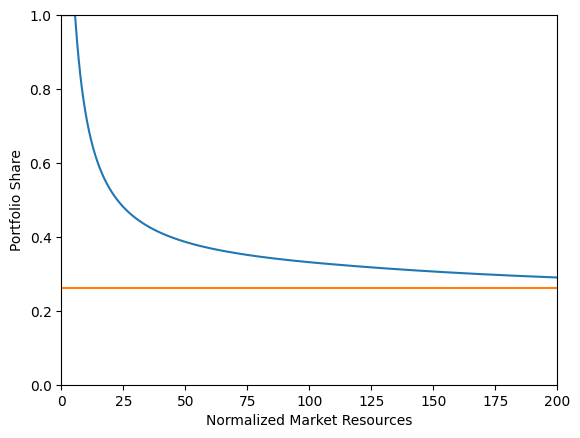

In [4]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources:")
plot_funcs(MyType.cFunc[0], 0.0, 20.0)
print("Risky asset share as a function of market resources:")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
# Since we are using a discretization of the lognormal distribution,
# the limit is numerically computed and slightly different from
# the analytical limit obtained by Merton and Samuelson for infinite wealth
plot_funcs(
    [
        MyType.ShareFunc[0],
        lambda m: MyType.ShareLimit * np.ones_like(m),
    ],
    0.0,
    200.0,
)

In [5]:
# Now simulate this consumer type
MyType.track_vars = ["cNrm", "Share", "aNrm", "t_age"]
MyType.T_sim = 100
MyType.initialize_sim()
MyType.simulate()

{'cNrm': array([[0.94545068, 1.05301389, 0.93655767, ..., 0.98554612, 0.85663682,
         1.1824275 ],
        [0.92410717, 1.0415238 , 0.69701186, ..., 1.00517765, 0.90218991,
         1.10714642],
        [0.93282041, 1.00976993, 0.38837518, ..., 0.95936591, 0.90034291,
         1.047398  ],
        ...,
        [0.92782049, 1.64990107, 1.15341011, ..., 1.31680457, 1.05417735,
         1.13995058],
        [0.92809779, 1.47274537, 1.07731849, ..., 1.22970287, 0.99801   ,
         1.08058639],
        [0.95225059, 1.51261424, 1.08287089, ..., 1.30303803, 1.02866737,
         1.1054343 ]]),
 'Share': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 0.74853661, 1.        , ..., 1.        , 1.        ,
         1.      

In [6]:
print("\n\n\n")
print("For derivation of the numerical limiting portfolio share")
print("as market resources approach infinity, see")
print(
    "https://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/Portfolio-CRRA/",
)





For derivation of the numerical limiting portfolio share
as market resources approach infinity, see
https://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/Portfolio-CRRA/


## 2. Discrete portfolio choice

In [7]:
# Make another example type, but this one optimizes risky portfolio share only
# on the discrete grid of values implicitly chosen by RiskyCount, using explicit
# value maximization.
DiscConsPortfolioDict = ConsPortfolioDict.copy()
DiscConsPortfolioDict["DiscreteShareBool"] = True
# Have to actually construct value function for this to work
DiscConsPortfolioDict["vFuncBool"] = True

In [8]:
# Create the discrete type using the dictionary, then change relevant attributes
DiscreteType = PortfolioConsumerType(**DiscConsPortfolioDict)
DiscreteType.cycles = 0

print("Now solving a discrete choice portfolio problem; this might take a minute...")

t0 = time()
DiscreteType.solve()
t1 = time()
DiscreteType.cFunc = [
    DiscreteType.solution[t].cFuncAdj for t in range(DiscreteType.T_cycle)
]
DiscreteType.ShareFunc = [
    DiscreteType.solution[t].ShareFuncAdj for t in range(DiscreteType.T_cycle)
]
print(
    "Solving an infinite horizon discrete portfolio choice problem took "
    + str(t1 - t0)
    + " seconds.",
)

Now solving a discrete choice portfolio problem; this might take a minute...
Solving an infinite horizon discrete portfolio choice problem took 21.95492124557495 seconds.


Consumption function over market resources:


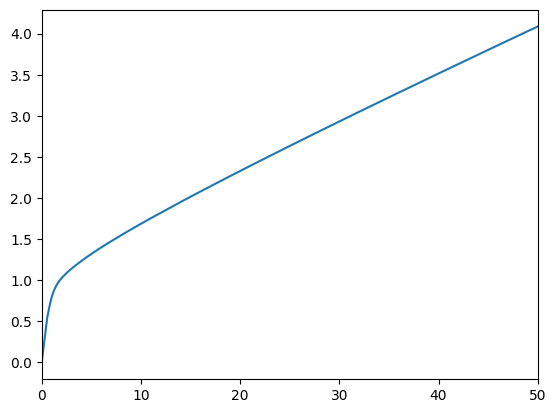

Risky asset share as a function of market resources:
Optimal (blue) versus Theoretical Limit (orange)


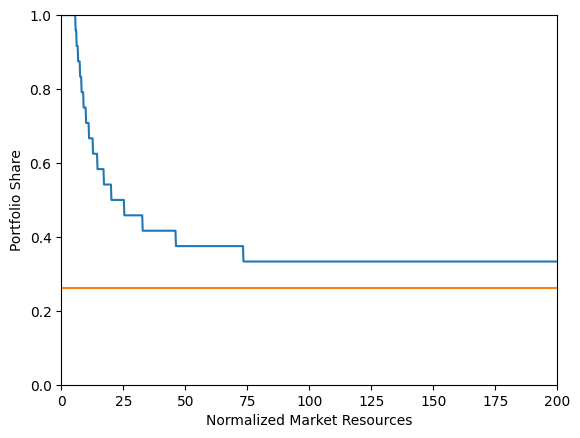

In [9]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources:")
plot_funcs(DiscreteType.cFunc[0], 0.0, 50.0)
print("Risky asset share as a function of market resources:")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
# Since we are using a discretization of the lognormal distribution,
# the limit is numerically computed and slightly different from
# the analytical limit obtained by Merton and Samuelson for infinite wealth
plot_funcs(
    [DiscreteType.ShareFunc[0], lambda m: DiscreteType.ShareLimit * np.ones_like(m)],
    0.0,
    200.0,
)

In [10]:
print("\n\n\n")

## 3. A model of "sticky" portfolio choice

In [11]:
# Make another example type, but this one can only update their risky portfolio
# share in any particular period with 15% probability.
StickyConsPortfolioDict = ConsPortfolioDict.copy()
StickyConsPortfolioDict["AdjustPrb"] = 0.15

In [12]:
# Make and solve a discrete portfolio choice consumer type
print(
    'Now solving a portfolio choice problem with "sticky" portfolio shares; this might take a moment...',
)
StickyType = PortfolioConsumerType(**StickyConsPortfolioDict)
StickyType.cycles = 0
t0 = time()
StickyType.solve()
t1 = time()
StickyType.cFuncAdj = [
    StickyType.solution[t].cFuncAdj for t in range(StickyType.T_cycle)
]
StickyType.cFuncFxd = [
    StickyType.solution[t].cFuncFxd for t in range(StickyType.T_cycle)
]
StickyType.ShareFunc = [
    StickyType.solution[t].ShareFuncAdj for t in range(StickyType.T_cycle)
]
print(
    "Solving an infinite horizon sticky portfolio choice problem took "
    + str(t1 - t0)
    + " seconds.",
)

Now solving a portfolio choice problem with "sticky" portfolio shares; this might take a moment...
Solving an infinite horizon sticky portfolio choice problem took 9.635167598724365 seconds.


Consumption function over market resources when the agent can adjust his portfolio:


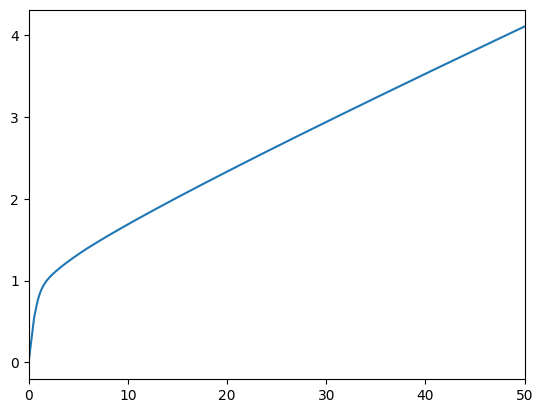

In [13]:
# Plot the consumption and risky-share functions
print(
    "Consumption function over market resources when the agent can adjust his portfolio:",
)
plot_funcs(StickyType.cFuncAdj[0], 0.0, 50.0)

Consumption function over market resources when the agent CAN'T adjust, by current share:


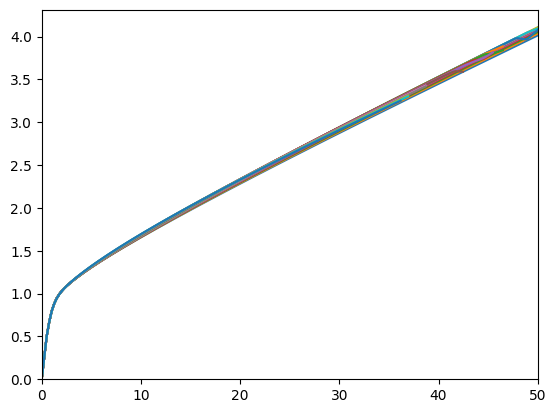

In [14]:
print(
    "Consumption function over market resources when the agent CAN'T adjust, by current share:",
)
M = np.linspace(0.0, 50.0, 200)
for s in np.linspace(0.0, 1.0, 21):
    C = StickyType.cFuncFxd[0](M, s * np.ones_like(M))
    plt.plot(M, C)
plt.xlim(0.0, 50.0)
plt.ylim(0.0, None)
plt.show()

Risky asset share function over market resources (when possible to adjust):
Optimal (blue) versus Theoretical Limit (orange)


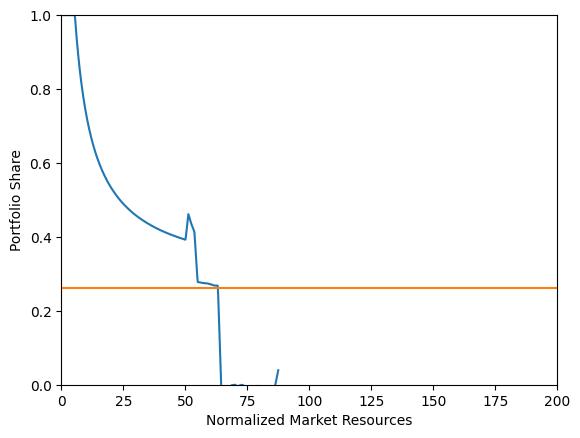

In [15]:
print("Risky asset share function over market resources (when possible to adjust):")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
plot_funcs(
    [StickyType.ShareFunc[0], lambda m: StickyType.ShareLimit * np.ones_like(m)],
    0.0,
    200.0,
)

Notice the wiggle in the blue line. This reflects the fact that the maximum grid point for which the solution is calculated is $a=100$ and the (incorrect) assumption built into the model that the portfolio share asymptotes to the frictionless analytical case. An alternative (not yet implemented) would be to calculate the implicit limit defined by the rate of geometric decay among the last grid points and assume that this is the limit.

The difference between the two is likely due to the agent's inability to adjust their portfolio.


## 4. Life-cycle model of portfolio choice

In [16]:
LC_ConsPortfolioDict = copy(ConsPortfolioDict)
LC_ConsPortfolioDict.update(time_params)
LC_ConsPortfolioDict.update(dist_params)
# Note the income specification overrides the pLvlInitMean from the SCF.
LC_ConsPortfolioDict.update(income_params)
LC_ConsPortfolioDict.update({"LivPrb": liv_prb})

LC_ConsPortfolioDict["RiskyAvg"] = [1.08] * init_lifecycle["T_cycle"]
LC_ConsPortfolioDict["RiskyStd"] = list(
    np.linspace(0.20, 0.30, init_lifecycle["T_cycle"]),
)
LC_ConsPortfolioDict["RiskyAvgTrue"] = 1.08
LC_ConsPortfolioDict["RiskyStdTrue"] = 0.20
AgeVaryingRiskPercType = PortfolioConsumerType(**LC_ConsPortfolioDict)
AgeVaryingRiskPercType.cycles = 1

In [17]:
# Solve the agent type with age-varying risk perceptions
# print('Now solving a portfolio choice problem with age-varying risk perceptions...')
t0 = time()
AgeVaryingRiskPercType.solve()
AgeVaryingRiskPercType.cFunc = [
    AgeVaryingRiskPercType.solution[t].cFuncAdj
    for t in range(AgeVaryingRiskPercType.T_cycle)
]
AgeVaryingRiskPercType.ShareFunc = [
    AgeVaryingRiskPercType.solution[t].ShareFuncAdj
    for t in range(AgeVaryingRiskPercType.T_cycle)
]
t1 = time()
print(
    "Solving a "
    + str(AgeVaryingRiskPercType.T_cycle)
    + " period portfolio choice problem with age-varying risk perceptions took "
    + str(t1 - t0)
    + " seconds.",
)

Solving a 65 period portfolio choice problem with age-varying risk perceptions took 2.6835877895355225 seconds.


Consumption function over market resources in each lifecycle period:


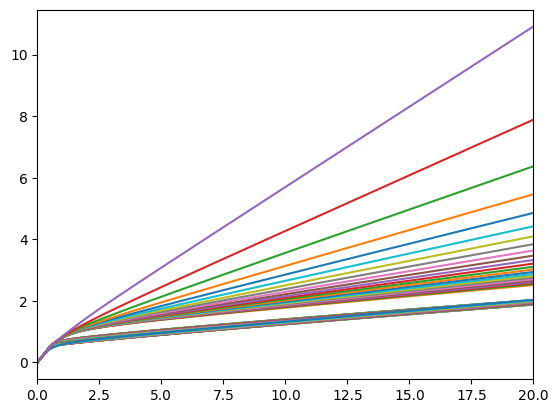

Risky asset share function over market resources in each lifecycle period:


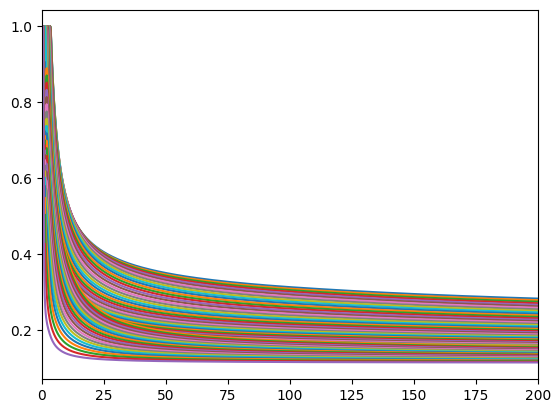

In [18]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources in each lifecycle period:")
plot_funcs(AgeVaryingRiskPercType.cFunc, 0.0, 20.0)
print("Risky asset share function over market resources in each lifecycle period:")
plot_funcs(AgeVaryingRiskPercType.ShareFunc, 0.0, 200.0)

## 5. Portfolio choice with Merton-Samuelson limiting shares

The code below tests the mathematical limits of the model and features the definition of a Merton-Samuelson type consumer.

In [19]:
# Create a grid of market resources for the plots
mMin = 0  # Minimum ratio of assets to income to plot
mMax = 5 * 1e2  # Maximum ratio of assets to income to plot
mPts = 1000  # Number of points to plot
plot_point_max = 1000
aXtraMax = plot_point_max * 10  # Maximum asset level

eevalgrid = np.linspace(0, mMax, mPts)  # range of values of assets for the plot

# Number of points that will be used to approximate the risky distribution
risky_count_grid = [5, 50, 200]
# Plot by ages (time periods) at which to plot. We will use the default life-cycle calibration.
ages = [2, 4, 6, 8]

In [20]:
# Creating the dictionary for the Merton-Samuelson consumer type
MertonPortfolioDict = copy(ConsPortfolioDict)
MertonPortfolioDict.update(time_params)
MertonPortfolioDict.update(dist_params)
# Note the income specification overrides the pLvlInitMean from the SCF.
MertonPortfolioDict.update(income_params)
MertonPortfolioDict.update({"LivPrb": liv_prb})

MertonPortfolioDict["RiskyAvgTrue"] = 1.08
MertonPortfolioDict["RiskyStdTrue"] = 0.20


# Create a function to compute the Merton-Samuelson limiting portfolio share.
def RiskyShareMertSamLogNormal(RiskPrem, CRRA, RiskyVar):
    return RiskPrem / (CRRA * RiskyVar)

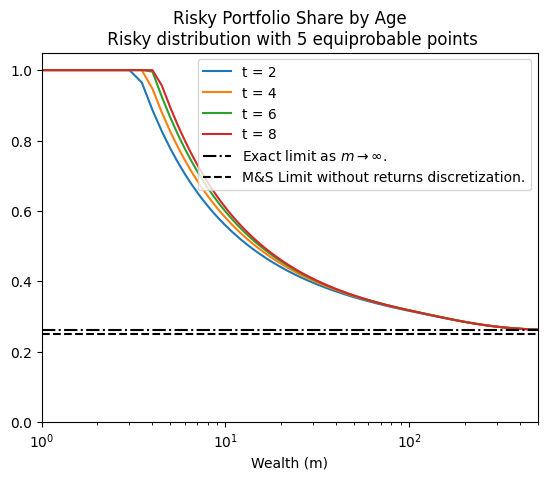

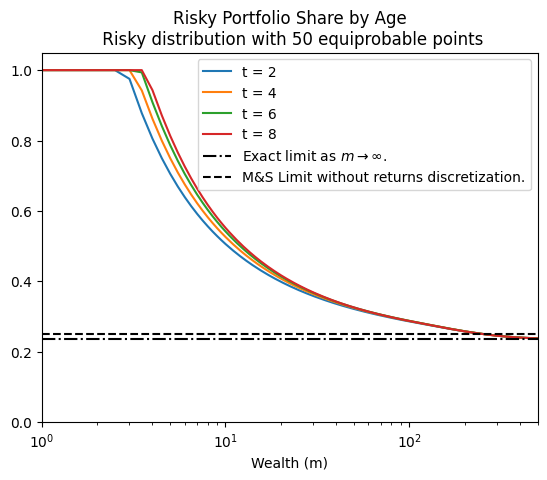

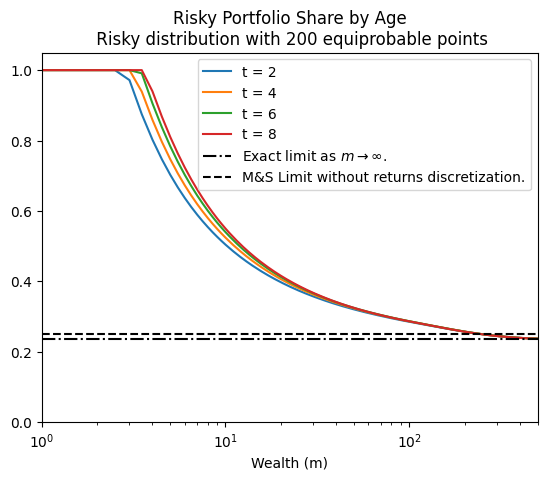

In [22]:
for rcount in risky_count_grid:
    # Create a new dictionary and replace the number of points that
    # approximate the risky return distribution

    # Create new dictionary copying the default.
    MertonPortfolioDict["RiskyCount"] = rcount

    # Create and solve agent
    agent = PortfolioConsumerType(**MertonPortfolioDict)
    agent.solve()

    # Compute the analytical Merton-Samuelson limiting portfolio share
    RiskyVar = agent.RiskyStd**2
    RiskPrem = agent.RiskyAvg - agent.Rfree
    MS_limit = RiskyShareMertSamLogNormal(RiskPrem, agent.CRRA, RiskyVar)

    # Now compute the limiting share numerically, using the approximated
    # distribution
    agent.construct("ShareLimit")
    NU_limit = agent.ShareLimit

    plt.figure()
    for a in ages:
        plt.plot(
            eevalgrid,
            agent.solution[a].ShareFuncAdj(eevalgrid),
            label="t = %i" % (a),
        )

    plt.axhline(
        NU_limit,
        c="k",
        ls="-.",
        label="Exact limit as $m\\rightarrow \\infty$.",
    )
    plt.axhline(
        MS_limit,
        c="k",
        ls="--",
        label="M&S Limit without returns discretization.",
    )

    plt.ylim(0, 1.05)
    plt.xlim(eevalgrid[0] + 1, eevalgrid[-1])
    plt.xscale("log")
    plt.legend()
    plt.title(
        f"Risky Portfolio Share by Age\n Risky distribution with {rcount} equiprobable points",
    )
    plt.xlabel("Wealth (m)")

    plt.ioff()
    plt.draw()